# Семинар 11. Нейронные сети

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
\DeclareMathOperator{\TP}{TP}
\DeclareMathOperator{\FP}{FP}
\DeclareMathOperator{\TN}{TN}
\DeclareMathOperator{\FN}{FN}
\DeclareMathOperator{\Accuracy}{Accuracy}
\DeclareMathOperator{\Precision}{Precision}
\DeclareMathOperator{\Recall}{Recall}
\DeclareMathOperator{\Fscore}{F_1}
\DeclareMathOperator{\MSE}{MSE}
\DeclareMathOperator{\RMSE}{RMSE}
\DeclareMathOperator{\MAE}{MAE}
\DeclareMathOperator{\MAPE}{MAPE}
\DeclareMathOperator{\Rsqured}{R^2}
$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

cm_bright = ListedColormap(['red', 'blue'])
cm = plt.cm.get_cmap('RdBu')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 4)

In [2]:
from sklearn import set_config

set_config(display='diagram')

In [3]:
import tensorflow as tf

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

Для наблюдения за процессом обучения:

In [4]:
from tqdm.auto import tqdm
from tensorflow.keras.callbacks import Callback


class ProgressCallback(Callback):
    def __init__(self, epochs):
        self.pbar = tqdm(total=epochs)

    def on_epoch_end(self, epoch, logs):
        if epoch % 128 == 0 or epoch >= self.pbar.total - 1:
            self.pbar.update(max(0, epoch - self.pbar.n))
            self.pbar.refresh()

Метрики в задаче регрессии:

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def regression_metrics(true, pred, verbose=False, plot=False):
    mae = mean_absolute_error(true, pred)
    mape = np.abs((true - pred) / true).mean()
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)
    return dict(zip(
        ['mae', 'mse', 'rmse', 'mape', 'r2'],
        [mae, mse, rmse, mape, r2]
    ))

Для демонстрации задачи классификации:

In [6]:
def plot_classification(X, y, model):
    pred = (model.predict(X).squeeze() > 0.5).astype(int)
    
    idx = (y == pred) & (y == 1)
    plt.scatter(X[idx, 0], X[idx, 1], color='blue', label='true=1, pred=1')

    idx = (y != pred) & (y == 1)
    plt.scatter(X[idx, 0], X[idx, 1], color='cyan', label='true=1, pred=0')

    idx = (y == pred) & (y == 0)
    plt.scatter(X[idx, 0], X[idx, 1], color='red', label='true=0, pred=0')

    idx = (y != pred) & (y == 0)
    plt.scatter(X[idx, 0], X[idx, 1], color='yellow', label='true=0, pred=1')

def plot_decision_map(X, y, model, proba=False):
    X1, X2 = X[:, 0], X[:, 1]
    
    x1_low, x1_high = X1.min(), X1.max()
    x2_low, x2_high = X2.min(), X2.max()
    d1, d2 = x1_high - x1_low, x2_high - x2_low
    
    x1_low -= d1 * 0.1
    x2_low -= d2 * 0.1
    x1_high += d1 * 0.1
    x2_high += d2 * 0.1
    
    
    X1 = np.linspace(x1_low, x1_high, 128)
    X2 = np.linspace(x2_low, x2_high, 128)
    X1, X2 = np.meshgrid(X1, X2)
    Z = np.c_[X1.flatten(), X2.flatten()]
    
    Z = model.predict(Z).squeeze()
    if not proba:
        Z = (Z > 0.5).astype(int)
    Z = Z.reshape(X1.shape)

    cmap = cm if proba else cm_bright
    plt.contourf(X1, X2, Z, cmap=cmap, alpha=0.2)
    
def plot_all(X, y, model, proba=False, title=''):
    plt.figure(0, (12, 8))
    plot_classification(X, y, model)
    plot_decision_map(X, y, model, proba=proba)
    
    plt.title(title)
    plt.legend()

# 1. Нейронные сети на Keras в задаче регрессии

In [7]:
from scipy.integrate import simps


def integrated_squared_error(y_true, y_pred, x):
    return simps(np.power(y_true - y_pred, 2), x)

In [8]:
def plot_results(model):
    x_plt = np.linspace(low, high, 1024)
    y_plt = model.predict(x_plt.reshape(-1, 1)).squeeze()
    error = integrated_squared_error(gt_func(x_plt), y_plt, x_plt)

    plt.scatter(X, y, color='blue', alpha=0.6)
    plt.axhline(0, color='black', alpha=0.5)
    plt.plot(x_plt, y_plt, ls='--', color='blue')
    plt.plot(x_plt, gt_func(x_plt), ls='--', color='green')
    plt.title(f'Error: {error:.5f}')
    plt.show()

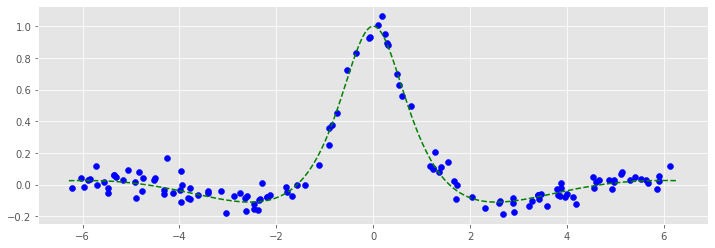

In [9]:
def gt_func(x):
    return np.cos(x) / (np.power(x, 2) + 1)

N = 128
noise_std = 0.05
low, high = -2 * np.pi, 2 * np.pi

np.random.seed(42)
X = np.random.uniform(low, high, N).reshape(-1, 1)
y = gt_func(X[:, 0]) + np.random.normal(scale=noise_std, size=N)

x_plt = np.linspace(low, high, 8192)
plt.scatter(X, y, color='blue')
plt.plot(x_plt, gt_func(x_plt), ls='--', color='green')
plt.show()

SVR(C=193.06977288832496, gamma=0.8619535664753032)

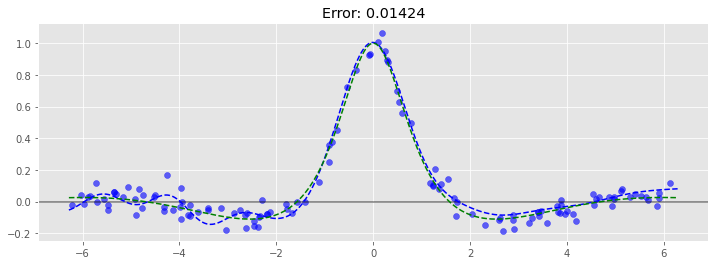

CPU times: user 726 ms, sys: 696 ms, total: 1.42 s
Wall time: 2.06 s


In [10]:
%%time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = SVR()
model = GridSearchCV(svr, {
    'C': np.logspace(-2, 4, 8),
    'gamma': np.logspace(-2, 3, 32)
}, n_jobs=-1)
model.fit(X, y)
display(model.best_estimator_)
plot_results(model)

## 1.1. Пример на синтетических данных

In [11]:
import tensorflow as tf
import tensorflow.keras as K

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Обучаем модель:

2022-03-14 17:07:49.843942: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  0%|          | 0/512 [00:00<?, ?it/s]

Model: "seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               256       
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________


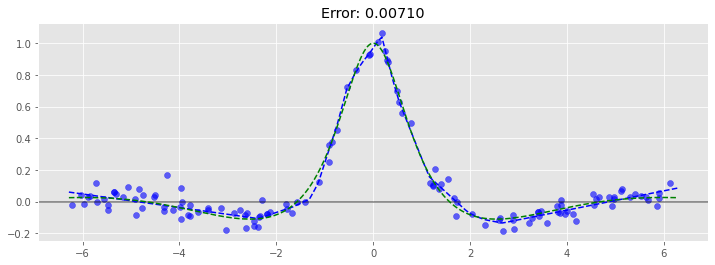

CPU times: user 11 s, sys: 3.13 s, total: 14.2 s
Wall time: 12.5 s


In [12]:
%%time
epochs = 512

# Модель
model = Sequential([
    Dense(128, activation='relu', input_dim=1),
    Dense(16, activation='relu'),
    Dense(1),
], name='seq')
optimizer = Adam(learning_rate=0.0025)
model.compile(optimizer, loss='mse', run_eagerly=False)

# обучение
fit_history = model.fit(X, y, 
    batch_size=128, 
    validation_split=0.1, 
    validation_freq=1, 
    epochs=epochs, 
    verbose=0,
    callbacks=[
        ProgressCallback(epochs)
    ]
)

model.summary()
plot_results(model)

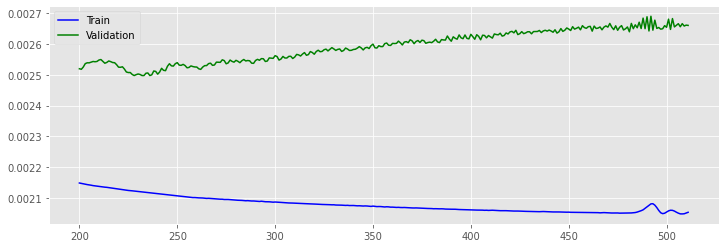

In [13]:
idx = np.arange(epochs)
start = 200

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')
plt.legend()
plt.show()

Добавляем регуляризацию:

  0%|          | 0/1024 [00:00<?, ?it/s]

Model: "seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               256       
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________


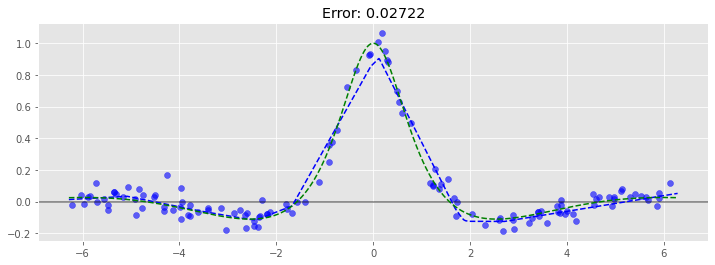

CPU times: user 21.7 s, sys: 6.26 s, total: 28 s
Wall time: 24.9 s


In [14]:
%%time
from tensorflow.keras.regularizers import l2


epochs = 1024
alpha = 1e-2

# Модель
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(alpha), input_dim=1),
    Dense(16, activation='relu', kernel_regularizer=l2(alpha)),
    Dense(1),
], name='seq')
optimizer = Adam(learning_rate=0.0025)
model.compile(optimizer, loss='mse', run_eagerly=False)

# обучение
fit_history = model.fit(X, y, 
    batch_size=128, 
    validation_split=0.1, 
    validation_freq=1, 
    epochs=epochs, 
    verbose=0,
    callbacks=[
        ProgressCallback(epochs)
    ]
)

model.summary()
plot_results(model)

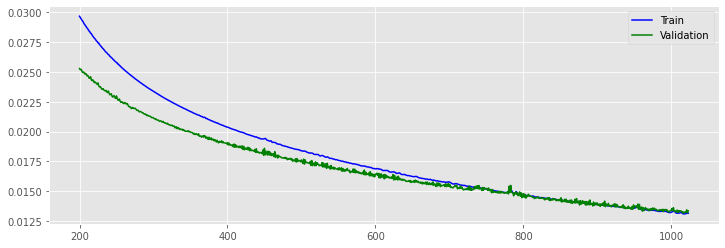

In [15]:
idx = np.arange(epochs)
start = 200

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')
plt.legend()
plt.show()

Уменьшаем learning_rate при выходе на плато:

  0%|          | 0/2048 [00:00<?, ?it/s]


Epoch 821: ReduceLROnPlateau reducing learning rate to 0.00024999999441206456.

Epoch 1364: ReduceLROnPlateau reducing learning rate to 2.4999998277053238e-05.

Epoch 1907: ReduceLROnPlateau reducing learning rate to 1e-05.
Model: "seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               256       
                                                                 
 dense_7 (Dense)             (None, 16)                2064      
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________


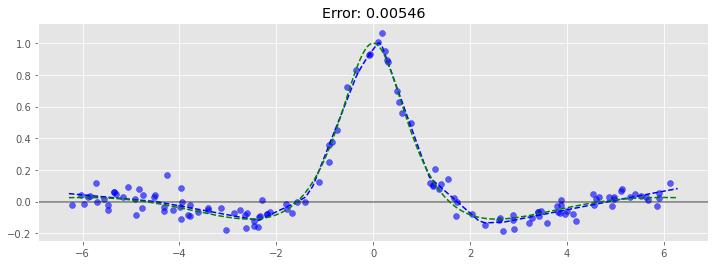

CPU times: user 42.3 s, sys: 12.3 s, total: 54.5 s
Wall time: 48.6 s


In [16]:
%%time
from tensorflow.keras.callbacks import ReduceLROnPlateau


epochs = 2048
alpha = 1e-3

# Модель
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(alpha), input_dim=1),
    Dense(16, activation='relu', kernel_regularizer=l2(alpha)),
    Dense(1),
], name='seq')
optimizer = Adam(learning_rate=0.0025)
model.compile(optimizer, loss='mse', run_eagerly=False)

# обучение
fit_history = model.fit(X, y, 
    batch_size=128, 
    validation_split=0.1, 
    validation_freq=1, 
    epochs=epochs, 
    verbose=0,
    callbacks=[
        ProgressCallback(epochs),
        ReduceLROnPlateau(patience=32, min_lr=1e-5, cooldown=512, verbose=1)
    ]
)

model.summary()
plot_results(model)

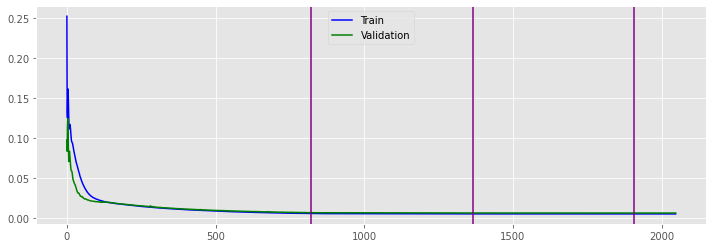

In [17]:
idx = np.arange(epochs)
start = 0

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')

lr = fit_history.history['lr']
for i in range(start, len(lr)):
    if ~np.isclose(lr[max(i - 1, 0)], lr[i]):
        plt.axvline(i, color='purple')
plt.legend()
plt.show()

## 1.2. Пример: расход топлива


Датасет __mpg__. По характеристикам машины необходимо спрогнозировать расход топлива.

Признаки:
* cylinders -- число цилиндров в двигателе;
* displacement -- рабочий объем, л;
* horsepower -- мощность, л.с.;
* weight -- вес, т;
* acceleration -- ускорение;
* model_year -- год выпуска модели;
* origin -- производитель;
* name -- название.

Целевая переменная:
* mpg -- миль на галлон, переведено в км/л.

In [18]:
frame = sns.load_dataset('mpg')
frame.dropna(inplace=True)

frame['displacement'] *= 16.3871 / 1000
frame['mpg'] = 100 / (frame.mpg * 1.60934 / 3.78541)
frame['weight'] *= 0.453592 / 1000

frame.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,13.067503,8,5.030840,130.0,1.589386,12.0,70,usa,chevrolet chevelle malibu
1,15.681004,8,5.735485,165.0,1.675115,11.5,70,usa,buick skylark 320
2,13.067503,8,5.211098,150.0,1.558542,11.0,70,usa,plymouth satellite
3,14.700941,8,4.981678,150.0,1.557181,12.0,70,usa,amc rebel sst
4,13.836180,8,4.948904,140.0,1.564439,10.5,70,usa,ford torino


In [19]:
X = frame.drop(columns=['mpg', 'name']).copy()
y = frame.mpg.copy()

Делим набор данных на привычные fit, test:

In [20]:
from sklearn.model_selection import train_test_split


X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Fit size:', X_fit.shape[0])
print('Test size:', X_test.shape[0])

Fit size: 313
Test size: 79


Отмасштабируем и закодируем признаки:

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


num_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year']
cat_features = ['origin']

transformer = make_column_transformer((StandardScaler(), num_features), 
                                      (OneHotEncoder(drop='first'), cat_features))
Xs_fit = transformer.fit_transform(X_fit)
Xs_test = transformer.transform(X_test)

In [22]:
%%time
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD


epochs = 1024
alpha=1e-3


# Модель
model = Sequential([
    Dense(32, kernel_regularizer=l2(alpha), bias_regularizer=l2(alpha), input_dim=Xs_fit.shape[1]),
    Dropout(0.2),
    ReLU(),
    Dense(1),
], name='seq')
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer, loss='mse', run_eagerly=False, steps_per_execution=10)

# обучение
fit_history = model.fit(Xs_fit, y_fit, 
    batch_size=64, 
    validation_split=0.1, 
    validation_freq=1, 
    epochs=epochs, 
    verbose=0,
    callbacks=[
        ProgressCallback(epochs)
    ]
)

model.summary()

  0%|          | 0/1024 [00:00<?, ?it/s]

Model: "seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                288       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
CPU times: user 24.8 s, sys: 7.53 s, total: 32.4 s
Wall time: 28 s


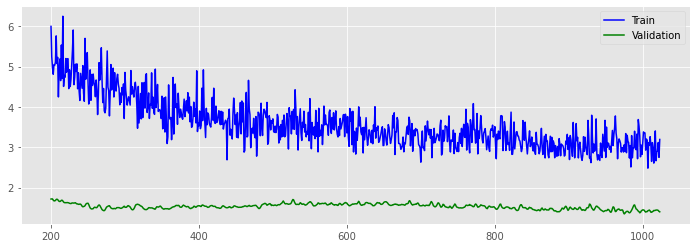

In [23]:
idx = np.arange(epochs)
start = 200

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')

plt.legend()
plt.show()

In [24]:
regression_metrics(y_test, model.predict(Xs_test).squeeze(), verbose=True)

{'mae': 0.9163250444401956,
 'mse': 1.407874790881969,
 'rmse': 1.186538996780961,
 'mape': 0.08462048590880224,
 'r2': 0.9007124365779595}

## 1.3. Keras и GridSearch

Модели в Keras не удовлетворяют требованиям Sklearn.
Для совместного использования с Pipeline и GridSearchCV нужно "обернуть" модель в специальный объект: 

In [25]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


def build_model(lr, n_hidden, dropout):
    # Модель
    model = Sequential()
    model.add(Dense(n_hidden, input_dim=8))
    model.add(Dropout(dropout))
    model.add(ReLU())
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer, loss='mse', run_eagerly=False)
    return model

net = KerasRegressor(build_model)

/tmp/ipykernel_67409/1161498582.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  net = KerasRegressor(build_model)


In [26]:
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
    ('transform', transformer),
    ('net', net)
])
pipeline

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('net',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x7febd9b84310>)])

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV, KFold


param_grid = {
    'net__lr': [1e-3],
    'net__dropout': [0.1, 0.2, 0.3],
    'net__n_hidden': [32, 64, 128],
    'net__epochs': [1536], 
    'net__batch_size': [64], 
    'net__verbose': [0]
}

gs = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose=51,
                  cv=KFold(10, shuffle=True, random_state=42),
                  scoring='neg_mean_squared_error')
gs.fit(X_fit, y_fit)
gs.best_params_

Fitting 10 folds for each of 9 candidates, totalling 90 fits


  0%|          | 0/90 [00:00<?, ?it/s]

2022-03-14 17:09:50.514283: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 17:09:50.559948: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 17:09:50.706797: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

[CV 6/10; 1/9] START net__batch_size=64, net__dropout=0.1, net__epochs=1536, net__lr=0.001, net__n_hidden=32, net__verbose=0
[CV 6/10; 1/9] END net__batch_size=64, net__dropout=0.1, net__epochs=1536, net__lr=0.001, net__n_hidden=32, net__verbose=0;, score=-1.543 total time=  23.7s


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 7/10; 1/9] START net__batch_size=64, net__dropout=0.1, net__epochs=1536, net__lr=0.001, net__n_hidden=32, net__verbose=0
[CV 7/10; 1/9] END net__batch_size=64, net__dropout=0.1, net__epochs=1536, net__lr=0.001, net__n_hidden=32, net__verbose=0;, score=-1.439 total time=  23.8s


In [ ]:
regression_metrics(y_test, gs.predict(X_test).squeeze(), verbose=True)

# 2. Нейронные сети на Keras в задаче классификации

In [ ]:
from sklearn.datasets import make_moons


X, y = make_moons(n_samples=256, 
                  shuffle=True,
                  noise=0.2,
                  random_state=42)

plt.figure(0, (12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
plt.show()

In [ ]:
%%time
epochs = 512

# Модель
model = Sequential([
    Dense(16, activation='relu', input_dim=2),
    Dropout(0.1),
    Dense(4, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid'),
], name='seq')
optimizer = Adam(learning_rate=0.003)
model.compile(optimizer, loss='binary_crossentropy')

# обучение
fit_history = model.fit(X, y, 
    batch_size=128, 
    validation_split=0.1, 
    validation_freq=1, 
    epochs=epochs, 
    verbose=0,
    callbacks=[
        ProgressCallback(epochs)
    ]
)

model.summary()
plot_all(X, y, model, proba=True)

In [ ]:
idx = np.arange(epochs)
start = 10

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')

plt.legend()
plt.show()

Круги:

In [ ]:
from sklearn.datasets import make_circles


X, y = make_circles(n_samples=256, 
                  shuffle=True,
                  noise=0.1, factor=0.7,
                  random_state=42)

plt.figure(0, (12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
plt.show()

In [ ]:
%%time
epochs = 768

# Модель
model = Sequential([
    Dense(16, activation='relu', input_dim=2),
    Dropout(0.2),
    Dense(4, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
], name='seq')
optimizer = Adam(learning_rate=0.0025)
model.compile(optimizer, loss='binary_crossentropy', run_eagerly=False, steps_per_execution=10)

# обучение
fit_history = model.fit(X, y, 
    batch_size=128, 
    validation_split=0.1, 
    validation_freq=1, 
    epochs=epochs, 
    verbose=0,
    callbacks=[
        ProgressCallback(epochs)
    ]
)

model.summary()
plot_all(X, y, model, proba=True)

In [ ]:
idx = np.arange(epochs)
start = 10

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')

plt.legend()
plt.show()